<h4 style="color:#aaff00"> Required Libraries<h4>

In [ ]:
import pandas as pd
import numpy as np
import io
import random
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_score

<h3 style="color:#00ffa5"> Loading Dataset </h3>

In [ ]:
df = pd.read_parquet("hf://datasets/ArianFiroozi/NNDL_HW5_S2025/data/train-00000-of-00001-982530f49cf10cee.parquet")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
df

,image,label,disease_name
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,7,Tomato__Tomato_YellowLeaf__Curl_Virus
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,7,Tomato__Tomato_YellowLeaf__Curl_Virus
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,1,Tomato_Spider_mites_Two_spotted_spider_mite
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2,Tomato_Bacterial_spot
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,8,Tomato_healthy
...,...,...,...
9320,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,6,Tomato_Early_blight
9321,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0,Tomato__Target_Spot
9322,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,7,Tomato__Tomato_YellowLeaf__Curl_Virus
9323,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2,Tomato_Bacterial_spot


<h3 style="color:#00ffa5"> Plotting Some Samples </h3>

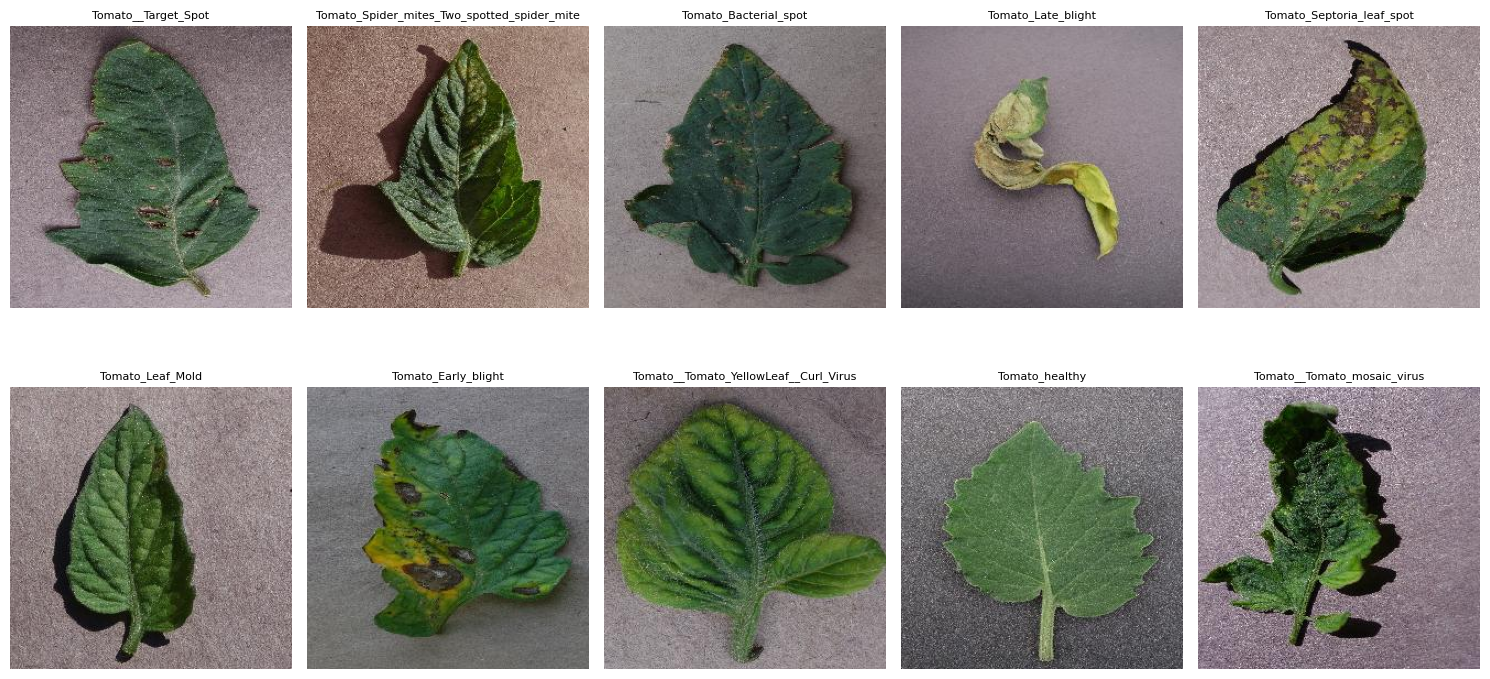

In [ ]:
sampled_df = df.drop_duplicates(subset='label', keep='first').sort_values(by='label')

plt.figure(figsize=(15, 8))
for idx, row in enumerate(sampled_df.itertuples()):
    image_bytes = row.image['bytes']
    image = Image.open(io.BytesIO(image_bytes))
    plt.subplot(2, 5, idx+1)
    plt.imshow(image)
    plt.title(f"{row.disease_name}", fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()


<h3 style="color:#00ffa5"> Checking Data Balance </h3>

                                  disease_name  count
0        Tomato__Tomato_YellowLeaf__Curl_Virus   1000
1  Tomato_Spider_mites_Two_spotted_spider_mite   1000
2                        Tomato_Bacterial_spot   1000
3                               Tomato_healthy   1000
4                    Tomato_Septoria_leaf_spot   1000
5                          Tomato_Early_blight   1000
6                           Tomato_Late_blight   1000
7                          Tomato__Target_Spot   1000
8                             Tomato_Leaf_Mold    952
9                  Tomato__Tomato_mosaic_virus    373


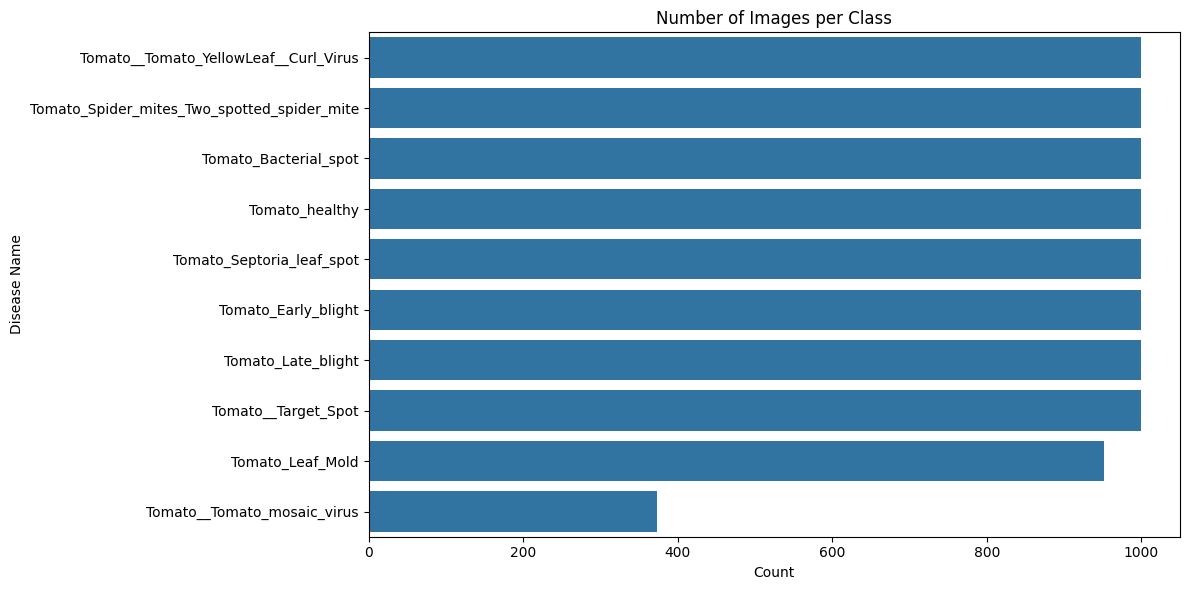

In [4]:
class_counts = df['disease_name'].value_counts().reset_index()
class_counts.columns = ['disease_name', 'count']
print(class_counts)


import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.barplot(data=class_counts, x='count', y='disease_name')
plt.title("Number of Images per Class")
plt.xlabel("Count")
plt.ylabel("Disease Name")
plt.tight_layout()
plt.show()


<h3 style="color:#00ffa5"> Data Augmentation </h3>

In [ ]:
# کلاس‌های هدف: کمتر از 1000 تصویر دارند
underrepresented_classes = class_counts[class_counts['count'] < 1000]

augmented_samples = []

def augment_image(img_bytes):
    img = Image.open(io.BytesIO(img_bytes)).convert('RGB')
    img = img.resize((224, 224))  # Resize for consistency
    img_tensor = tf.convert_to_tensor(np.array(img), dtype=tf.uint8)

    # Augmentations
    img_tensor = tf.image.random_flip_left_right(img_tensor)
    img_tensor = tf.image.random_brightness(img_tensor, max_delta=0.1)
    img_tensor = tf.image.random_contrast(img_tensor, lower=0.9, upper=1.1)

    # Convert back to PIL
    return Image.fromarray(img_tensor.numpy())

# تولید داده‌های تقویت‌شده برای هر کلاس
for _, row in underrepresented_classes.iterrows():
    cls_name = row['disease_name']
    count = row['count']
    n_needed = 1000 - count

    class_df = df[df['disease_name'] == cls_name]

    for _ in range(n_needed):
        sample = class_df.sample(1).iloc[0]
        new_img = augment_image(sample.image['bytes'])
        buf = io.BytesIO()
        new_img.save(buf, format='JPEG')

        augmented_samples.append({
            'image': {'bytes': buf.getvalue()},
            'label': sample.label,
            'disease_name': sample.disease_name
        })

# ساخت دیتافریم جدید متوازن
augmented_df = pd.DataFrame(augmented_samples)
df_balanced = pd.concat([df, augmented_df], ignore_index=True)

# بررسی توازن نهایی
final_counts = df_balanced['disease_name'].value_counts()
print(final_counts)


disease_name
Tomato__Tomato_YellowLeaf__Curl_Virus          1000
Tomato_Spider_mites_Two_spotted_spider_mite    1000
Tomato_Bacterial_spot                          1000
Tomato_healthy                                 1000
Tomato_Septoria_leaf_spot                      1000
Tomato_Leaf_Mold                               1000
Tomato__Tomato_mosaic_virus                    1000
Tomato_Early_blight                            1000
Tomato__Target_Spot                            1000
Tomato_Late_blight                             1000
Name: count, dtype: int64


<h3 style="color:#00ffa5"> Data Setting & Split </h3>


In [ ]:
NUM_CLASSES = 10
IMG_SIZE = (299, 299)

def parse_and_preprocess(img_bytes, label):
    img = tf.io.decode_jpeg(img_bytes, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32)
    img = tf.keras.applications.inception_v3.preprocess_input(img)

    label_onehot = tf.one_hot(label, NUM_CLASSES)
    label_onehot = tf.cast(label_onehot, tf.float32)

    return img, label_onehot


In [ ]:
BATCH_SIZE = 64

train_df, val_df = train_test_split(
    df_balanced,
    test_size=0.1,
    stratify=df_balanced['label'],
    random_state=42
)

def generator_from_df(dataframe):
    for _, row in dataframe.iterrows():
        yield row['image']['bytes'], row['label']

def make_tf_dataset(dataframe, shuffle=False):
    ds = tf.data.Dataset.from_generator(
        lambda: generator_from_df(dataframe),
        output_types=(tf.string, tf.int32),
        output_shapes=((), ())
    )
    if shuffle:
        ds = ds.shuffle(buffer_size=2048)
    ds = ds.map(
        parse_and_preprocess,
        num_parallel_calls=tf.data.AUTOTUNE
    )
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_tf_dataset(train_df, shuffle=True)
val_ds   = make_tf_dataset(val_df,   shuffle=False)


<h3 style="color:#ffb600"> Inception-V3 Model Setting </h3>

In [ ]:
base_model = tf.keras.applications.InceptionV3(
    include_top=False,
    weights=None,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D(name="gap")(x)
output = tf.keras.layers.Dense(
    NUM_CLASSES,
    activation="softmax",
    name="predictions"
)(x)

model = tf.keras.Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 149, 149,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 149, 149,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 147, 147,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 147, 147,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 73, 73,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 73, 73,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 73,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 73, 73,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 71, 71,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 71, 71,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 71, 71,    │          0 │ batch_normalizat

 Total params: 21,823,274 (83.25 MB)

 Trainable params: 21,788,842 (83.12 MB)

 Non-trainable params: 34,432 (134.50 KB)

<h3 style="color:#ffb600"> Training </h3>

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
)

Epoch 1/30
    141/Unknown 249s 1s/step - accuracy: 0.5489 - loss: 1.3843   

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


141/141 ━━━━━━━━━━━━━━━━━━━━ 262s 1s/step - accuracy: 0.5497 - loss: 1.3816 - val_accuracy: 0.0890 - val_loss: 6.3596
Epoch 2/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 195s 1s/step - accuracy: 0.8060 - loss: 0.6010 - val_accuracy: 0.1110 - val_loss: 6.1356
Epoch 3/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.8549 - loss: 0.4408 - val_accuracy: 0.3420 - val_loss: 4.0188
Epoch 4/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.8825 - loss: 0.3546 - val_accuracy: 0.7950 - val_loss: 0.8006
Epoch 5/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.9081 - loss: 0.2681 - val_accuracy: 0.7040 - val_loss: 4.3248
Epoch 6/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.9269 - loss: 0.2203 - val_accuracy: 0.6830 - val_loss: 1.3750
Epoch 7/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 150s 742ms/step - accuracy: 0.9423 - loss: 0.1684 - val_accuracy: 0.8590 - val_loss: 0.5014
Epoch 8/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 108s 761ms/step - accuracy: 0.9443 - loss: 0.1652 - val_accuracy:

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
model_h5_path = "/content/drive/MyDrive/DL_Models/ViT_model.h5"
vit_model.save(model_h5_path)

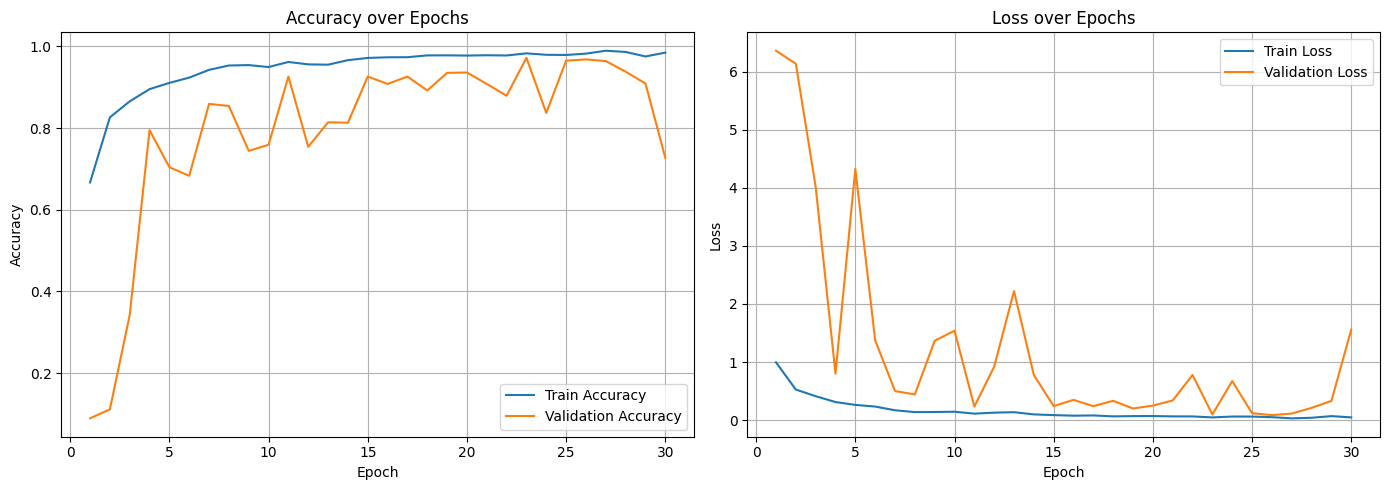

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


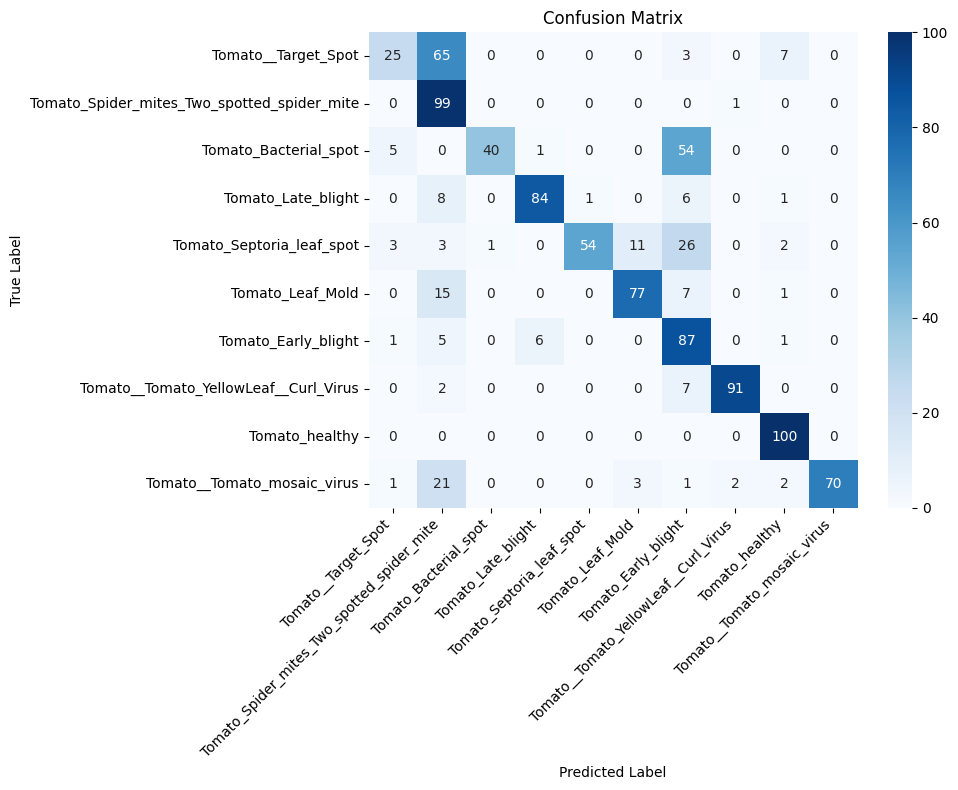

In [ ]:
y_true = []
y_pred = []

for batch_images, batch_labels in val_ds:
    preds = model.predict(batch_images, verbose=0)
    y_true.extend(tf.argmax(batch_labels, axis=1).numpy())
    y_pred.extend(tf.argmax(preds, axis=1).numpy())

cm = confusion_matrix(y_true, y_pred)

label_map = df_balanced[['label', 'disease_name']].drop_duplicates().sort_values('label')
class_names = label_map['disease_name'].tolist()

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

<h3 style="color:#ffb600"> ViT Model Setting</h3>

In [ ]:
NUM_CLASSES = 10
IMG_SIZE_VIT = (224, 224)

def parse_and_preprocess_vit(img_bytes, label):
    img = tf.io.decode_jpeg(img_bytes, channels=3)
    img = tf.image.resize(img, IMG_SIZE_VIT)
    img = tf.cast(img, tf.float32)
    img = (img / 127.5) - 1.0
    label_onehot = tf.one_hot(label, NUM_CLASSES)
    label_onehot = tf.cast(label_onehot, tf.float32)
    return img, label_onehot

train_df, val_df = train_test_split(
    df_balanced,
    test_size=0.1,
    stratify=df_balanced['label'],
    random_state=42
)

def generator_from_df(dataframe):
    for _, row in dataframe.iterrows():
        yield row['image']['bytes'], row['label']

def make_vit_dataset(dataframe, shuffle=False, batch_size=32):
    ds = tf.data.Dataset.from_generator(
        lambda: generator_from_df(dataframe),
        output_types=(tf.string, tf.int32),
        output_shapes=((), ())
    )
    if shuffle:
        ds = ds.shuffle(buffer_size=2048)
    ds = ds.map(
        parse_and_preprocess_vit,
        num_parallel_calls=tf.data.AUTOTUNE
    )
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds_vit = make_vit_dataset(train_df, shuffle=True, batch_size=32)
val_ds_vit   = make_vit_dataset(val_df,   shuffle=False, batch_size=32)

In [ ]:
class Patcher(tf.keras.layers.Layer):
    def __init__(self, patch_size):
        super(Patcher, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding='VALID'
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


class PatchEmbedding(tf.keras.layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEmbedding, self).__init__()
        self.projection = tf.keras.layers.Dense(units=projection_dim)
        self.pos_embedding = tf.keras.layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
        self.num_patches = num_patches

    def call(self, patches):
        embeddings = self.projection(patches)
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        pos_embed = self.pos_embedding(positions)
        return embeddings + pos_embed


class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, mlp_dim, dropout_rate=0.1):
        super(TransformerBlock, self).__init__()
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.attn = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=dropout_rate
        )
        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)

        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(mlp_dim, activation='gelu'),
            tf.keras.layers.Dropout(dropout_rate),
            tf.keras.layers.Dense(embed_dim),
            tf.keras.layers.Dropout(dropout_rate)
        ])

    def call(self, x, training=None):
        x_norm1 = self.norm1(x)
        attn_output = self.attn(x_norm1, x_norm1, training=training)
        attn_output = self.dropout1(attn_output, training=training)
        x = x + attn_output

        x_norm2 = self.norm2(x)
        ffn_output = self.ffn(x_norm2, training=training)
        return x + ffn_output


In [ ]:
def build_vit_model(
    input_shape=(224, 224, 3),
    patch_size=16,
    projection_dim=64,
    num_heads=4,
    num_layers=8,
    mlp_dim=128,
    num_classes=10,
    dropout_rate=0.1
):
    num_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)
    inputs = tf.keras.Input(shape=input_shape)

    patches = Patcher(patch_size)(inputs)
    embeddings = PatchEmbedding(num_patches, projection_dim)(patches)

    x = embeddings
    for _ in range(num_layers):
        x = TransformerBlock(
            embed_dim=projection_dim,
            num_heads=num_heads,
            mlp_dim=mlp_dim,
            dropout_rate=dropout_rate)(x)

    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)

    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
vit_model = build_vit_model(
    input_shape=(224, 224, 3),
    patch_size=16,
    projection_dim=64,
    num_heads=4,
    num_layers=8,
    mlp_dim=128,
    num_classes=10,
    dropout_rate=0.1
)

vit_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

vit_model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ patcher (Patcher)               │ (None, None, 768)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ patch_embedding                 │ (None, 196, 64)        │        61,760 │
│ (PatchEmbedding)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block               │ (None, 196, 64)        │        83,200 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_1             │ (None, 196, 64)        │        83,200 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_2             │ (None, 196, 64)        │        83,200 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_3             │ (None, 196, 64)        │        83,200 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_4             │ (None, 196, 64)        │        83,200 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_5             │ (None, 196, 64)        │        83,200 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_6             │ (None, 196, 64)        │        83,200 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_7             │ (None, 196, 64)        │        83,200 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_16          │ (None, 196, 64)        │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 728,138 (2.78 MB)

 Trainable params: 728,138 (2.78 MB)

 Non-trainable params: 0 (0.00 B)

<h3 style="color:#ffb600"> Training </h3>

In [12]:
history_vit = vit_model.fit(
    train_ds_vit,
    validation_data=val_ds_vit,
    epochs=20
)

Epoch 1/20
    282/Unknown 90s 144ms/step - accuracy: 0.4474 - loss: 1.5796

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


282/282 ━━━━━━━━━━━━━━━━━━━━ 95s 165ms/step - accuracy: 0.4479 - loss: 1.5781 - val_accuracy: 0.7890 - val_loss: 0.6610
Epoch 2/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 38s 101ms/step - accuracy: 0.8006 - loss: 0.5935 - val_accuracy: 0.8520 - val_loss: 0.3974
Epoch 3/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 41s 102ms/step - accuracy: 0.8670 - loss: 0.3910 - val_accuracy: 0.9060 - val_loss: 0.2587
Epoch 4/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 41s 100ms/step - accuracy: 0.9042 - loss: 0.2858 - val_accuracy: 0.8870 - val_loss: 0.3553
Epoch 5/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 19s 63ms/step - accuracy: 0.9028 - loss: 0.2777 - val_accuracy: 0.9390 - val_loss: 0.1985
Epoch 6/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 19s 64ms/step - accuracy: 0.9209 - loss: 0.2469 - val_accuracy: 0.9000 - val_loss: 0.2918
Epoch 7/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 19s 63ms/step - accuracy: 0.9265 - loss: 0.2070 - val_accuracy: 0.9570 - val_loss: 0.1455
Epoch 8/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 20s 63ms/step - accuracy: 0.9378 - loss: 0.1952 - val_acc

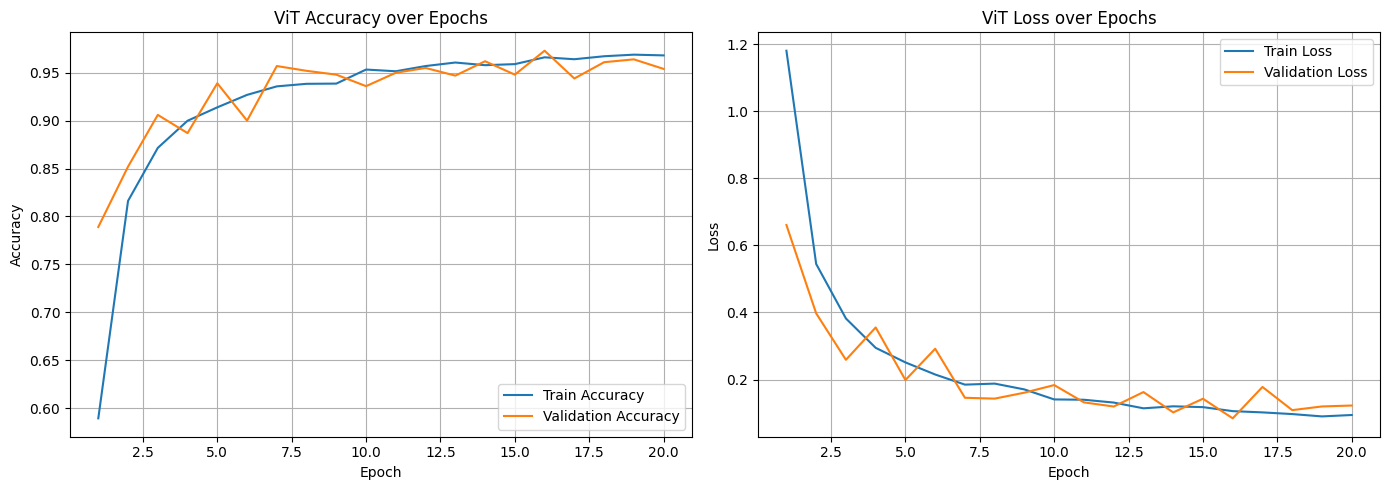

In [ ]:
acc = history_vit.history['accuracy']
val_acc = history_vit.history['val_accuracy']
loss = history_vit.history['loss']
val_loss = history_vit.history['val_loss']
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('ViT Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('ViT Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


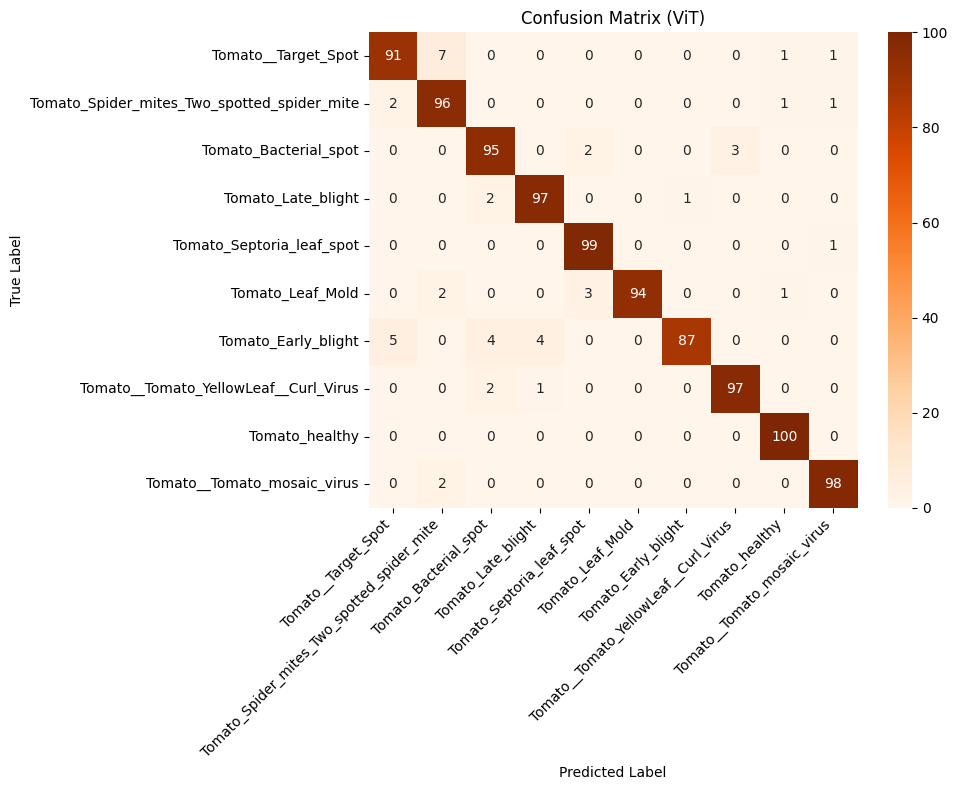

In [ ]:
y_true = []
y_pred = []

for images, labels in val_ds_vit:
    preds = vit_model.predict(images, verbose=0)
    y_true.extend(tf.argmax(labels, axis=1).numpy())
    y_pred.extend(tf.argmax(preds, axis=1).numpy())

cm_vit = confusion_matrix(y_true, y_pred)

class_names = df_balanced[['label', 'disease_name']] \
                .drop_duplicates().sort_values('label')['disease_name'].tolist()

plt.figure(figsize=(10, 8))
sns.heatmap(cm_vit, annot=True, fmt='d', cmap='Oranges',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix (ViT)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
report = classification_report(
    y_true,
    y_pred,
    target_names=class_names,
    digits=4
)
print(report)

precisions = precision_score(y_true, y_pred, average=None)
for cls_name, p in zip(class_names, precisions):
    print(f"{cls_name:<50} precision = {p:.4f}")


                                             precision    recall  f1-score   support

                        Tomato__Target_Spot     0.9286    0.9100    0.9192       100
Tomato_Spider_mites_Two_spotted_spider_mite     0.8972    0.9600    0.9275       100
                      Tomato_Bacterial_spot     0.9223    0.9500    0.9360       100
                         Tomato_Late_blight     0.9510    0.9700    0.9604       100
                  Tomato_Septoria_leaf_spot     0.9519    0.9900    0.9706       100
                           Tomato_Leaf_Mold     1.0000    0.9400    0.9691       100
                        Tomato_Early_blight     0.9886    0.8700    0.9255       100
      Tomato__Tomato_YellowLeaf__Curl_Virus     0.9700    0.9700    0.9700       100
                             Tomato_healthy     0.9709    1.0000    0.9852       100
                Tomato__Tomato_mosaic_virus     0.9703    0.9800    0.9751       100

                                   accuracy                    